# Import from Database and Analysis
This notebook imports shared Craigslist listings from the database on Istanbul for initial data exploration and analysis.

In [30]:
#import packages
import pandas as pd
import numpy as np
import re as re
import json    # library for working with JSON-formatted text strings
import requests  # library for accessing content from web URLs
import pprint  # library for making Python data structures readable
import psycopg2
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
pp = pprint.PrettyPrinter()
pd.options.mode.chained_assignment = None #disables warnings for editing copy of a dataframe
pd.set_option('display.float_format', lambda x: '%.3f' % x) #describe() vars are not in scientific notation
pd.set_option('max_columns', 30)
%matplotlib inline

In [17]:
# Defining font styles for graphics
family = 'Arial'
title_font = fm.FontProperties(family=family, style='normal', size=18, weight='normal', stretch='normal')
label_font = fm.FontProperties(family=family, style='normal', size=16, weight='normal', stretch='normal')
ticks_font = fm.FontProperties(family=family, style='normal', size=14, weight='normal', stretch='normal')

In [18]:
# Creating function for defining colors for graphics
def get_colors(cmap, n, start=0., stop=1., alpha=1., reverse=False):
    '''return n-length list of rgba colors from the passed colormap name and alpha,
       limit extent by start/stop values and reverse list order if flag is true'''
    colors = [cm.get_cmap(cmap)(x) for x in np.linspace(start, stop, n)]
    colors = [(r, g, b, alpha) for r, g, b, _ in colors]
    return list(reversed(colors)) if reverse else colors

In [4]:
# Read in credentials from private settings file
with open('settings.json') as settings_file:    
    settings = json.load(settings_file)

In [5]:
#try to connect to database on local machine
dbname = settings['dbname']
user = settings['user']
host = settings['host']
password = settings['password']

conn_str = "dbname = {0} user = {1} host = {2} password = {3}".format(dbname, user, host, password)

try:
    conn = psycopg2.connect(conn_str)
except:
    print ("I am unable to connect to the database")

In [6]:
# example dataframe with all the listings (as of 04/24, about 23k listings)
df = pd.read_sql_query("select * from shared_listings;",con=conn)

In [7]:
df['region'].value_counts()

newyork         14610
sfbay            5491
losangeles       4869
washingtondc     4694
boston           2999
miami            2718
sandiego         2184
chicago          1989
houston          1860
atlanta          1741
philadelphia     1681
orangecounty     1673
denver           1420
seattle          1389
orlando          1333
baltimore        1250
inlandempire     1235
newjersey        1212
austin           1184
tampa            1151
portland         1123
phoenix          1117
lasvegas          982
dallas            913
sacramento        909
minneapolis       824
norfolk           742
raleigh           724
indianapolis      670
nashville         622
                ...  
northplatte         4
butte               4
enid                4
klamath             4
ottumwa             4
eastoregon          4
bemidji             4
quincy              4
salina              4
owensboro           4
clovis              3
lewiston            3
showlow             3
bismarck            3
greatfalls

### Example SQL pulls

In [ ]:
# example syntax for pulling just those from newyork domain
df_nyc = pd.read_sql_query("select * from shared_listings where region = 'newyork';",con=conn)

In [ ]:
# example syntax for pulling just those on a specific date (April 22)
df_april25 = pd.read_sql_query("select * from shared_listings where dt >= '2017-04-25' AND dt < '2017-04-23';",con=conn)

In [ ]:
# example syntax for pulling just those on a specific date (April 22)
df_april25 = pd.read_sql_query("select * from shared_listings where dt >= '2017-04-25';",con=conn)

In [ ]:
df_april24 = pd.read_sql_query("select * from shared_listings where dt >= '2017-04-24'AND dt < '2017-04-25';",con=conn)

In [ ]:
df_april23 = pd.read_sql_query("select * from shared_listings where dt >= '2017-04-23'AND dt < '2017-04-24';",con=conn)

In [ ]:
#close database connection (no longer needed)
conn.close()

### De-Duplication

In [8]:
df.loc[df.lat == 99, 'lat'] = 0
df.loc[df.lng == 99, 'lng'] = 0
df.loc[df.sqft == 0, 'sqft'] = np.nan

#For any duplicate post, we want to keep the version with the most information. Therefore, assign a score to each post and 
#give one point for square footage, lat, long and price

df['price_exists'] = df['rent']>0
df['sqft_exists'] = df['sqft']>0
df['lat_exists'] = df['lat']>0
df['lng_exists'] = df['lng']<0
df['score'] = df[['price_exists','sqft_exists','lat_exists','lng_exists']].astype(bool).sum(axis=1)

In [9]:
#Sort rows by score
df = df.sort_values(by='score',ascending=False)

In [10]:
dedupe1 = pd.DataFrame(df.drop_duplicates(subset='body_text', inplace=False))

In [11]:
dedupe1.shape

(68106, 28)

In [12]:
dedupe2 = pd.DataFrame(dedupe1.drop_duplicates(subset='pid', inplace=False))

In [13]:
dedupe2.shape

(66269, 28)

### Quick bar chart to see impact of deduplication on sample size

In [19]:
y = [len(df),len(dedupe1), len(dedupe2)]
labels = ['original', 'dedupe-body', 'dedupe-pid']
x = [1,2,3]

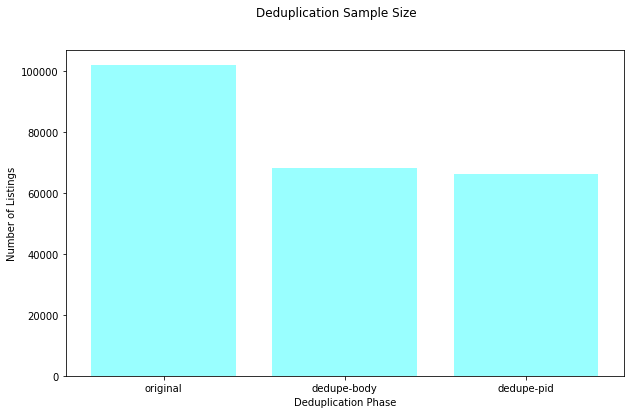

In [20]:
plt.figure(figsize=(10,6) )
plt.suptitle('Deduplication Sample Size')
plt.xlabel('Deduplication Phase')
plt.ylabel('Number of Listings')
plt.xticks(x, labels)
ax = plt.bar(x, y, alpha=.4, color='cyan', align='center')
plt.show()

### More Filtering

In [21]:
unique_wprice = dedupe2[dedupe2['rent'] > 0]

In [22]:
unique_wprice.shape

(55469, 28)

In [23]:
# in this cell, define the values by which we will filter the 3 columns. This will vary depending on the sample we're looking at. 
upper_percentile = 0.997
lower_percentile = 0.08

# how many rows would be within the upper and lower percentiles?
upper = int(len(unique_wprice) * upper_percentile)
lower = int(len(unique_wprice) * lower_percentile)

# get the rent values at the upper and lower percentiles
rent_sorted = unique_wprice['rent'].sort_values(ascending=True, inplace=False)
upper_rent = rent_sorted.iloc[upper]
lower_rent = rent_sorted.iloc[lower]

# get the sqft values at the upper and lower percentiles
sqft_sorted = unique_wprice['sqft'].sort_values(ascending=True, inplace=False)
upper_sqft = sqft_sorted.iloc[upper]
lower_sqft = sqft_sorted.iloc[lower]

print('valid rent range:', [lower_rent, upper_rent])
print('valid sqft range:', [lower_sqft, upper_sqft])

valid rent range: [300.0, 6000.0]
valid sqft range: [220.0, nan]


In [24]:
#Filtering out rows with unreasonable rent prices 
rent_mask = (unique_wprice['rent'] > lower_rent) & (unique_wprice['rent'] < upper_rent)

In [25]:
filtered_listings = pd.DataFrame(unique_wprice[rent_mask])

In [26]:
filtered_listings.shape

(50434, 28)

### Full Filtered Database Charts

In [27]:
listings_ratios = pd.DataFrame()

#Number of total shared listings for reach region before deduplication or filtering
listings_ratios['all_shared_listings'] = df['region'].value_counts()

listings_ratios['deduplicated_text'] = dedupe1['region'].value_counts()

listings_ratios['deduplicated_pid'] = dedupe2['region'].value_counts()

listings_ratios['duplicate_listings'] = listings_ratios['all_shared_listings'] - listings_ratios['deduplicated_pid'] 

listings_ratios['duplicate_ratio'] = listings_ratios['duplicate_listings']/listings_ratios['all_shared_listings']

listings_ratios['unique_ratio'] = listings_ratios['deduplicated_pid']/listings_ratios['all_shared_listings']

In [28]:
listings_ratios.head()

,all_shared_listings,deduplicated_text,deduplicated_pid,duplicate_listings,duplicate_ratio,unique_ratio
newyork,14610,7159.000,7065.000,7545.000,0.516,0.484
sfbay,5491,4416.000,4322.000,1169.000,0.213,0.787
losangeles,4869,3303.000,3222.000,1647.000,0.338,0.662
washingtondc,4694,3245.000,3190.000,1504.000,0.320,0.680
boston,2999,2041.000,1976.000,1023.000,0.341,0.659


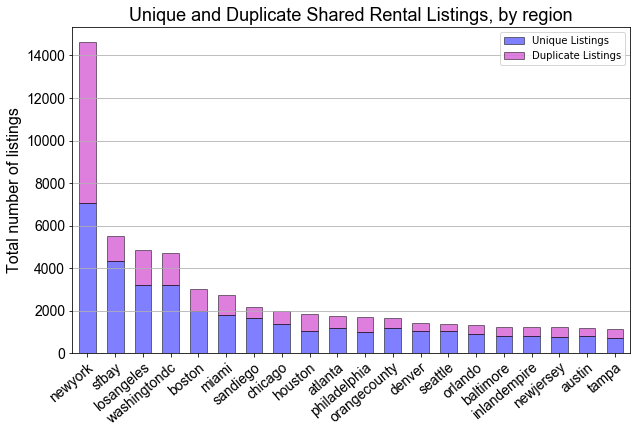

In [38]:
# plot the ratios of unique and duplicate listings, by region. This is before dropping observations without lat-lngs!

countdata = listings_ratios.sort_values(by='all_shared_listings', ascending=False)[['deduplicated_pid','duplicate_listings']].head(20)
countdata.columns = ['Unique Listings', 'Duplicate Listings']
ax = countdata.plot(kind='bar',
                    stacked=True,
                    figsize=[10, 6], 
                    width=0.6, 
                    alpha=0.5, 
                    color=['b','m'],
                    edgecolor='k',
                    grid=False)

ax.yaxis.grid(True)
ax.set_xticks(range(0, len(countdata)))
ax.set_xticklabels(countdata.index, rotation=40, rotation_mode='anchor', ha='right', fontproperties=ticks_font)
for label in ax.get_yticklabels():
        label.set_fontproperties(ticks_font)
ax.set_title('Unique and Duplicate Shared Rental Listings, by region', fontproperties=title_font)
ax.set_xlabel('', fontproperties=label_font)
ax.set_ylabel('Total number of listings', fontproperties=label_font)        

#save_fig(plt.gcf(), 'count_unique_duplicate_listings.png')
plt.show()

## Spatial Join for Census Tracts

In [39]:
import geopandas as gpd

from geopandas import GeoDataFrame
from shapely.geometry import Point
from geopy.distance import great_circle

from scipy import ndimage

import matplotlib.pylab as pylab
import matplotlib.pyplot as plt
pylab.rcParams['figure.figsize'] = 10, 8
import fiona

### California Regions

In [40]:
california = gpd.read_file('ca_census_shapefile//cb_2015_06_tract_500k.shp')
print(type(california))
print(california.crs)

<class 'geopandas.geodataframe.GeoDataFrame'>
{'init': 'epsg:4269'}


In [41]:
#Use California CRS
# California.crs = {'init' :'epsg:2227'}
#http://spatialreference.org/ref/epsg/2227/
california_crs = {'init': 'epsg:2227'}
california = california.to_crs(california_crs)
print(california.crs)

{'init': 'epsg:2227'}


In [42]:
sfbay = filtered_listings[filtered_listings['region']=='sfbay']

In [44]:
sfbay = sfbay[sfbay.lat != 0]

In [46]:
los_angeles = filtered_listings[filtered_listings['region']=='losangeles']

In [47]:
los_angeles = los_angeles[los_angeles.lat != 0]

### LA GeoJSON

In [50]:
geometryMapping_la = [Point(xy) for xy in zip(los_angeles.lng, los_angeles.lat)]
geo_la = GeoDataFrame(los_angeles, crs={'init' :'epsg:4326'}, geometry=geometryMapping_la)
geo_la=geo_la.to_crs(california_crs)
print(type(geo_la))
print(geo_la.crs)

<class 'geopandas.geodataframe.GeoDataFrame'>
{'init': 'epsg:2227'}


### SF GeoJSON

In [51]:
geometryMapping = [Point(xy) for xy in zip(sfbay.lng, sfbay.lat)]
geo_sf = GeoDataFrame(sfbay, crs={'init' :'epsg:4326'}, geometry=geometryMapping)
geo_sf=geo_sf.to_crs(california_crs)
print(type(geo_sf))
print(geo_sf.crs)

<class 'geopandas.geodataframe.GeoDataFrame'>
{'init': 'epsg:2227'}


In [52]:
la_joined = gpd.sjoin(geo_la, california, how='inner', op='intersects')

In [53]:
sf_joined = gpd.sjoin(geo_sf, california, how="inner", op='intersects')

In [54]:
la_joined.shape

(2198, 39)

In [55]:
# Dropping unnecessary fields that came from Census shapefile
la_joined.drop(['ALAND','LSAD','NAME','AWATER','AFFGEOID','STATEFP','COUNTYFP'], axis=1, inplace=True)
sf_joined.drop(['ALAND','LSAD','NAME','AWATER','AFFGEOID','STATEFP','COUNTYFP'], axis=1, inplace=True)

### Mapping

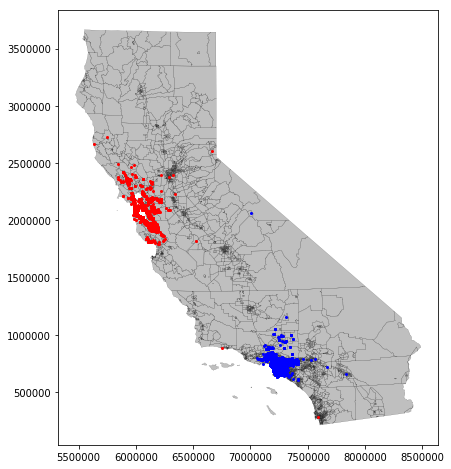

In [56]:
base = california.plot(color='gray', linewidth=.1)
sf_joined.plot(color='red', ax=base)
la_joined.plot(color='b', ax=base)
plt.show()

### Comparing Vacant to Shared Listings

In [57]:
vacant = pd.read_csv('vacant_april_listings.csv',dtype={'fips_block':str})

In [58]:
# Creating a GEOID field that's comparable to shared listings
vacant['GEOID'] = vacant['fips_block'].str[:-4]

In [59]:
# Turning studios into 1BRs for calculating rent per bedroom
vacant['beds2'] = vacant['beds']
vacant.loc[vacant.beds2 == 0, 'beds2'] = 1


In [60]:
vacant['rent_per_br'] = vacant['rent']/vacant['beds2']

In [61]:
# in this cell, define the values by which we will filter the 3 columns. This will vary depending on the sample we're looking at. 
upper_percentile = 0.99
lower_percentile = 0.01

# how many rows would be within the upper and lower percentiles?
upper = int(len(vacant) * upper_percentile)
lower = int(len(vacant) * lower_percentile)

# get the rent/sqft values at the upper and lower percentiles
rent_sqft_sorted = vacant['rent_sqft'].sort_values(ascending=True, inplace=False)
upper_rent_sqft = rent_sqft_sorted.iloc[upper]
lower_rent_sqft = rent_sqft_sorted.iloc[lower]

# get the rent values at the upper and lower percentiles
rent_sorted = vacant['rent'].sort_values(ascending=True, inplace=False)
upper_rent = rent_sorted.iloc[upper]
lower_rent = rent_sorted.iloc[lower]

# get the sqft values at the upper and lower percentiles
sqft_sorted = vacant['sqft'].sort_values(ascending=True, inplace=False)
upper_sqft = sqft_sorted.iloc[upper]
lower_sqft = sqft_sorted.iloc[lower]

print('valid rent_sqft range:', [lower_rent_sqft, upper_rent_sqft])
print('valid rent range:', [lower_rent, upper_rent])
print('valid sqft range:', [lower_sqft, upper_sqft])

valid rent_sqft range: [0.36067551266599995, 4.9182839632300004]
valid rent range: [425.0, 4890.0]
valid sqft range: [360.0, 2740.0]


In [62]:
#Filtering out rows with unreasonable rent prices 
rent_mask = (vacant['rent'] > lower_rent) & (vacant['rent'] < upper_rent)

In [63]:
filtered_vacant = pd.DataFrame(vacant[rent_mask])

In [66]:
# Snapshot of median prices for total sample
print('median rent for all vacant listings:', filtered_vacant['rent'].median())
print('median rent for all vacant Studio Units:',(filtered_vacant[filtered_vacant['beds']==0])['rent_per_br'].median())
print('median rent for all vacant 1BR Units:',(filtered_vacant[filtered_vacant['beds']==1])['rent_per_br'].median())

print('median rent per bedroom for all vacant listings:', filtered_vacant['rent_per_br'].median())
print('median rent per bedroom for all multi-bedroom vacant listings:', (filtered_vacant[filtered_vacant['beds'] > 1])['rent_per_br'].median())

median rent for all vacant listings: 1230.0
median rent for all vacant Studio Units: 1267.0
median rent for all vacant 1BR Units: 1101.0
median rent per bedroom for all vacant listings: 760.0
median rent per bedroom for all multi-bedroom vacant listings: 562.5


In [67]:
vacant_sfbay = vacant[vacant['region']=='sfbay']

In [68]:
vacant_sfbay.shape

(44285, 17)

In [76]:
# Note: If we apply a filter for individual regions, we'd probably want to adjust the parameters to account for the smaller 
# sample size and different market; for example, $5000 is not a super atypical price in the Bay Area, shouldn't be filtered out 
print('median rent for all SF vacant listings:', vacant_sfbay['rent'].median())
print('median rent for all SF vacant Studio Units:',(vacant_sfbay[vacant_sfbay['beds']==0])['rent_per_br'].median())
print('median rent for all SF vacant 1BR Units:',(vacant_sfbay[vacant_sfbay['beds']==1])['rent_per_br'].median())

print('median rent per bedroom for all SF vacant listings:', vacant_sfbay['rent_per_br'].median())
print('median rent per bedroom for all SF multi-bedroom vacant listings:', (vacant_sfbay[vacant_sfbay['beds'] > 1])['rent_per_br'].median())

median rent for all SF vacant listings: 2695.0
median rent for all SF vacant Studio Units: 2189.0
median rent for all SF vacant 1BR Units: 2330.0
median rent per bedroom for all SF vacant listings: 1757.0
median rent per bedroom for all SF multi-bedroom vacant listings: 1375.0


In [77]:
sf_joined['rent'].median()

1074.5

In [79]:
vacant_la = vacant[vacant['region']=='losangeles']

In [ ]:
#vacant2 = vacant[(vacant['GEOID'] != '')]

In [85]:
# Grouping and aggragating by GEOID
sf_grouped = vacant_sfbay.groupby(by='GEOID')
#sf_grouped.agg({'rent_per_br':['mean','median','count']})

rent_per_br               
                   mean   median count
GEOID                                 
06001400100    1554.303 1633.333    11
06001400200    2073.750 2047.500     4
06001400300    2412.234 2125.000    47
06001400400    1844.123 1800.000    19
06001400500    1812.500 1875.000    11
06001400600    1709.848 1600.000    11
06001400700    1814.885 1900.000    13
06001400800    1380.833 1425.000    14
06001400900    2080.000 2000.000     5
06001401000    1457.889 1395.000    15
06001401100    1516.389 1362.500    24
06001401200    1714.083 1491.250    10
06001401300    2597.130 2903.000    69
06001401400    1485.000 1382.500    10
06001401500     940.625  850.000     8
06001401600    1001.250  975.000    10
06001401700    1812.269 1650.000    13
06001401800    1421.250 1421.250     4
06001402200    1832.292 1737.500     8
06001402400    1533.750 1695.000     4
06001402500    1304.167 1400.000     4
06001402600    1398.667 1400.000     5
06001402700    1073.042 1020.000     8
06001402800    2144.826 1965.000    45
06001402900    2157.241 2295.000    27
06001403000    1726.250 1583.750    10
06001403100    1986.692 1722.500    26
06001403300    2305.118 2387.000   114
06001403400    2198.942 2195.000    78
06001403501    2706.008 2913.000    85
...                 ...      ...   ...
06097153502    2250.000 2250.000     1
06097153600    1512.500 1512.500     2
06097153703     982.431  891.667    12
06097153704     940.417  983.333     4
06097153705    1059.722 1000.000     9
06097153706    1575.000 1575.000     3
06097153801     805.556  812.500     3
06097153804     887.500  887.500     2
06097153806     866.667  866.667     1
06097153808     989.515  950.000    11
06097153901    1137.500 1137.500     2
06097153902    1340.500 1125.000     8
06097153903     835.000  800.000    10
06097154000    1250.000 1250.000     4
06097154201    1088.889 1200.000     3
06097154202    1073.333  825.000     5
06097154302    1233.333 1200.000     3
06097154303     685.000  663.333     4
06097154304    1215.000 1350.000     5
06099000909     533.333  533.333     1
06099000912     733.333  733.333     1
06109003200    2400.000 2400.000     1
06113010606     898.333  898.333     1
12086018900     421.667  421.667     1
12097041500     400.000  400.000     1
15003008622    1166.667 1166.667     2
32003005805     973.750  973.750     1
35027960400      75.000   75.000     4
40143007625     522.500  522.500     1
45003020702     515.000  515.000     2

[1584 rows x 3 columns]

Empty DataFrame
Columns: [(rent_per_br, mean), (rent_per_br, median), (rent_per_br, count)]
Index: []

## Visualz

In [70]:
listings_ratios['all_vacant_listings'] = vacant['region'].value_counts()
listings_ratios['shared_to_vacant_ratio'] = listings_ratios['deduplicated_pid']/listings_ratios['all_vacant_listings']

In [75]:
listings_ratios.head()

,all_shared_listings,deduplicated_text,deduplicated_pid,duplicate_listings,duplicate_ratio,unique_ratio,all_vacant_listings,shared_to_vacant_ratio
newyork,14610,7159.000,7065.000,7545.000,0.516,0.484,10993.000,0.643
sfbay,5491,4416.000,4322.000,1169.000,0.213,0.787,44285.000,0.098
losangeles,4869,3303.000,3222.000,1647.000,0.338,0.662,44792.000,0.072
washingtondc,4694,3245.000,3190.000,1504.000,0.320,0.680,57007.000,0.056
boston,2999,2041.000,1976.000,1023.000,0.341,0.659,8396.000,0.235


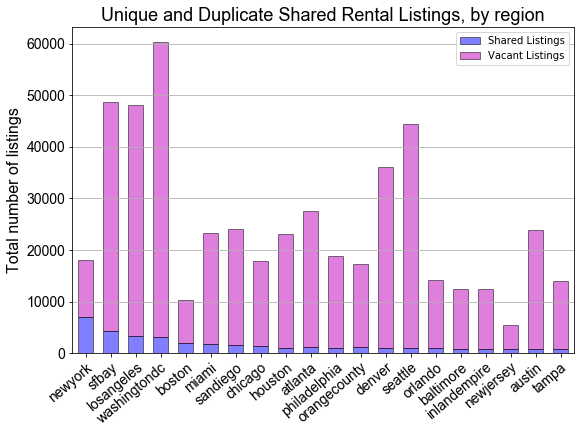

In [74]:
# plot the ratios of unique and duplicate listings, by region
countdata = listings_ratios.sort_values(by='all_shared_listings', ascending=False)[['deduplicated_pid','all_vacant_listings']].head(20)
countdata.columns = ['Shared Listings', 'Vacant Listings']
ax = countdata.plot(kind='bar',
                    stacked=True,
                    figsize=[9, 6], 
                    width=0.6, 
                    alpha=0.5, 
                    color=['b','m'],
                    edgecolor='k',
                    grid=False)

ax.yaxis.grid(True)
ax.set_xticks(range(0, len(countdata)))
ax.set_xticklabels(countdata.index, rotation=40, rotation_mode='anchor', ha='right', fontproperties=ticks_font)
for label in ax.get_yticklabels():
        label.set_fontproperties(ticks_font)
ax.set_title('Unique and Duplicate Shared Rental Listings, by region', fontproperties=title_font)
ax.set_xlabel('', fontproperties=label_font)
ax.set_ylabel('Total number of listings', fontproperties=label_font)        

#save_fig(plt.gcf(), 'count_unique_duplicate_listings.png')
plt.show()